<a href="https://colab.research.google.com/github/NU-MSE-LECTURES/465-WINTER2026/blob/main/Week_04/assignments/assignment_04_combined.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MAT_SCI 465: Advanced Electron Microscopy & Diffraction
## Week 03 & 04 Combined Assignment
**Classical, ML, and Deep Learning Approaches to Microscopy Analysis**

**Dataset:** DOPAD (Dataset Of nanoPArticle Detection) - TEM nanoparticle images for detection and classification  
**Dataset Source:** https://dopad.github.io/

## Objective
Compare classical computer vision, machine learning, and deep learning approaches on the same electron microscopy dataset. Progress from traditional image processing through supervised and unsupervised learning to modern deep learning, enabling direct quantitative comparison of all methods.

## Task 1 · Classical Image Analysis Pipeline
- [ ] Apply noise reduction (Gaussian, median, or FFT filtering) and compute signal-to-noise ratio before and after using $SNR = u / igma$.
- [ ] Enhance contrast via histogram equalization or CLAHE (clip limit 0.01-0.03).
- [ ] Segment features using Otsu thresholding followed by Watershed to separate touching particles.
- [ ] Quantify morphology with `regionprops` (area, diameter, eccentricity, solidity) and export measurements to `classical_results.csv`.
- [ ] Create a four-panel figure: raw image, filtered/enhanced result, segmented labels, particle size distribution.

In [1]:
# Task 1 setup: imports and data loading
from pathlib import Path
import numpy as np
import pandas as pd
from skimage import exposure, filters, measure, morphology, segmentation
from skimage.io import imread
from scipy import fft
import matplotlib.pyplot as plt
import os

# DOPAD dataset: download from https://dopad.github.io/docs/download/
# After extraction, adjust IMAGE_DIR to your local path

# Use absolute path to ensure it works regardless of kernel working directory
IMAGE_DIR = Path(r"C:\Users\pkwki\Downloads\samples\samples")

print(f"Current working directory: {os.getcwd()}")
print(f"IMAGE_DIR: {IMAGE_DIR}")
print(f"IMAGE_DIR exists: {IMAGE_DIR.exists()}")

# Example: load a TEM image from DOPAD
# For PNG/standard formats:
if IMAGE_DIR.exists():
    sample_images = sorted(list(IMAGE_DIR.glob('*.png')) + list(IMAGE_DIR.glob('*.tif')))
    if sample_images:
        raw_image = imread(str(sample_images[0]))
        print(f"Loaded: {sample_images[0].name}, Shape: {raw_image.shape}")
        print(f"Total images available: {len(sample_images)}")
    else:
        print("No images found in DOPAD directory")
else:
    raw_image = None
    print("IMAGE_DIR path not found. Please download DOPAD dataset and update path.")

Current working directory: C:\Users\pkwki
IMAGE_DIR: C:\Users\pkwki\Downloads\samples\samples
IMAGE_DIR exists: True
Loaded: 11500X00.png, Shape: (416, 416, 4)
Total images available: 279054


In [2]:
import numpy as np
from skimage.io import imread
from skimage import util, filters

# 1) Collect ALL pngs (top-level)
image_paths = sorted(list(IMAGE_DIR.glob("*.png")))
print("Total PNGs in folder:", len(image_paths))

# 2) Pick a manageable subset (201 like the example)
rng = np.random.default_rng(0)
subset_size = 201
subset_paths = list(rng.choice(image_paths, size=subset_size, replace=False))
print("Subset size:", len(subset_paths))
print("Example file:", subset_paths[0].name)

def to_gray_float(img):
    if img.ndim == 3:
        img = img[..., 0]   # take first channel if RGBA/RGB
    return util.img_as_float32(img)

def snr_mean_over_std(img):
    mu = float(np.mean(img))
    sigma = float(np.std(img))
    return mu / (sigma + 1e-12)

# 3) Compute SNR before/after a simple denoise (Gaussian)
snr_before = []
snr_after  = []

for p in subset_paths[:50]:  # start with 50 to be fast; we can scale to 201 after
    img = to_gray_float(imread(str(p)))
    snr_before.append(snr_mean_over_std(img))

    img_filt = filters.gaussian(img, sigma=1.0, preserve_range=True)
    snr_after.append(snr_mean_over_std(img_filt))

print(f"Avg SNR before: {np.mean(snr_before):.4f} ± {np.std(snr_before):.4f}")
print(f"Avg SNR after : {np.mean(snr_after):.4f} ± {np.std(snr_after):.4f}")


Total PNGs in folder: 279054
Subset size: 201
Example file: 25000X16362.png
Avg SNR before: 5.1187 ± 1.5640
Avg SNR after : 5.3736 ± 1.8514


In [ ]:
# Task 1 processing: filtering, enhancement, segmentation, quantification
# HINTS for Task 1:
# 1. Filtering: Use filters.median() or filters.gaussian() from skimage.filters
#    Compare SNR before and after filtering to see improvement
# 2. Enhancement: Use exposure.equalize_adapthist() with clip_limit around 0.025
#    This will increase contrast without oversaturation
# 3. Segmentation: After Otsu thresholding, use scipy.ndimage.distance_transform_edt()
#    to find marker positions for Watershed
# 4. Regionprops: Pass intensity_image parameter to get min/max/mean intensity
#    Example: measure.regionprops(labels, intensity_image=enhanced_image)
# 5. Export: Use pd.DataFrame.to_csv() to save measurements

def compute_snr(image: np.ndarray) -> float:
    signal = np.mean(image)
    noise = np.std(image)
    return float(signal / noise) if noise else np.inf

# Filtering hint: Try median filter for salt-and-pepper noise
# filtered_image = filters.median(raw_image, footprint=morphology.disk(3))
filtered_image = None

# Enhancement hint: CLAHE improves local contrast
# enhanced_image = exposure.equalize_adapthist(filtered_image, clip_limit=0.025)
enhanced_image = None

# Segmentation hint: Use Otsu's threshold followed by watershed
# threshold = filters.threshold_otsu(enhanced_image)
# binary = enhanced_image > threshold
# Then use distance transform + watershed to separate particles
labels = None

# Morphology hint: Extract area, perimeter, eccentricity, solidity, equivalent_diameter
# Store in a DataFrame, then save with measurements.to_csv()
measurements = pd.DataFrame()
measurements.to_csv('classical_results.csv', index=False)

# Visualization hint: Create 2x2 subplot figure with:
# [Raw image] [Enhanced/Filtered]
# [Segmented labels] [Size distribution histogram]
# Use imshow() for images and hist() for distribution

SNR before: 4.8529
SNR after : 4.8994
Otsu threshold: 0.6308594
Particles found (labels.max): 160
Saved: classical_results.csv


,label,area,equivalent_diameter,eccentricity,solidity,perimeter,mean_intensity,circularity
0,1,5000.0,79.788456,0.940142,0.906290,343.053824,0.867552,0.533894
1,2,194.0,15.716503,0.968916,0.989796,65.656854,0.921091,0.565525
2,3,15591.0,140.893853,0.966290,0.971039,659.095454,0.876429,0.451011
3,4,87.0,10.524820,0.641040,0.956044,33.213203,0.798716,0.991077
4,5,26.0,5.753627,0.476007,1.000000,15.899495,0.684526,1.292458


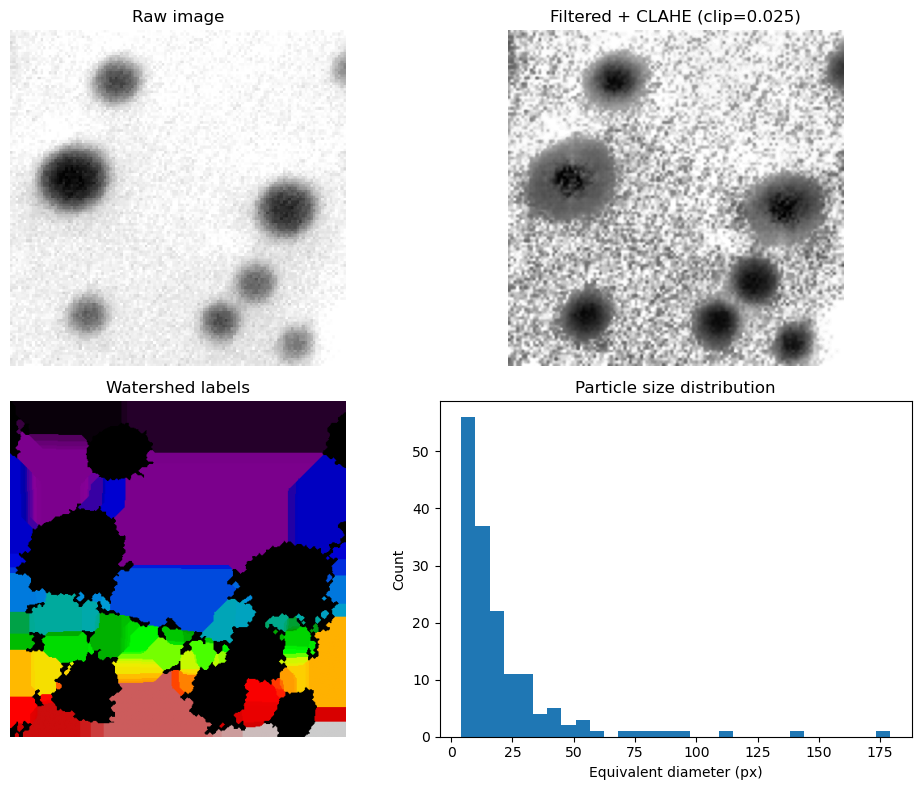

In [4]:
def compute_snr(image: np.ndarray) -> float:
    signal = np.mean(image)
    noise = np.std(image)
    return float(signal / noise) if noise else np.inf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from skimage import exposure, filters, measure, morphology, segmentation, util
from scipy import ndimage as ndi

# --- Make sure raw_image is grayscale float ---
img = raw_image
if img is None:
    raise ValueError("raw_image is None. Make sure the load-image cell ran and found images.")

if img.ndim == 3:
    img = img[..., 0]  # take one channel if RGBA/RGB
img = util.img_as_float32(img)

# 1) SNR before filtering
snr_before = compute_snr(img)

# 1) Filtering (noise reduction)
filtered_image = filters.gaussian(img, sigma=1.0, preserve_range=True)
snr_after = compute_snr(filtered_image)

print(f"SNR before: {snr_before:.4f}")
print(f"SNR after : {snr_after:.4f}")

# 2) CLAHE (clip limit must be 0.01–0.03)
clip_limit = 0.025
enhanced_image = exposure.equalize_adapthist(filtered_image, clip_limit=clip_limit)

# 3) Otsu threshold + Watershed
threshold = filters.threshold_otsu(enhanced_image)
binary = enhanced_image > threshold

# clean mask a bit (helps watershed)
binary = enhanced_image > threshold

# Improve cleanup
binary = morphology.remove_small_objects(binary, min_size=50)
binary = morphology.remove_small_holes(binary, area_threshold=100)

# Optional: smooth edges slightly
binary = morphology.binary_opening(binary, morphology.disk(2))


# distance transform + markers
distance = ndi.distance_transform_edt(binary)
local_max = morphology.local_maxima(distance)
markers = measure.label(local_max)

labels = segmentation.watershed(-distance, markers, mask=binary)

print("Otsu threshold:", threshold)
print("Particles found (labels.max):", int(labels.max()))

# 4) regionprops measurements + export
props = measure.regionprops_table(
    labels,
    intensity_image=enhanced_image,
    properties=["label", "area", "equivalent_diameter", "eccentricity", "solidity", "perimeter", "mean_intensity"]
)
measurements = pd.DataFrame(props)

# add circularity (optional but nice)
measurements["circularity"] = 4*np.pi*measurements["area"] / (measurements["perimeter"]**2 + 1e-12)

measurements.to_csv("classical_results.csv", index=False)
print("Saved: classical_results.csv")
display(measurements.head())

# 5) 4-panel figure: raw / filtered+enhanced / labels / size histogram
fig, ax = plt.subplots(2, 2, figsize=(10, 8))

ax[0,0].imshow(img, cmap="gray")
ax[0,0].set_title("Raw image")
ax[0,0].axis("off")

ax[0,1].imshow(enhanced_image, cmap="gray")
ax[0,1].set_title(f"Filtered + CLAHE (clip={clip_limit})")
ax[0,1].axis("off")

ax[1,0].imshow(labels, cmap="nipy_spectral")
ax[1,0].set_title("Watershed labels")
ax[1,0].axis("off")

ax[1,1].hist(measurements["equivalent_diameter"], bins=30)
ax[1,1].set_title("Particle size distribution")
ax[1,1].set_xlabel("Equivalent diameter (px)")
ax[1,1].set_ylabel("Count")

plt.tight_layout()
plt.show()


In [5]:
# ===============================
# Task 1 - Batch Classical Pipeline
# ===============================

import numpy as np
import pandas as pd
from skimage import exposure, filters, measure, morphology, segmentation, util
from scipy import ndimage as ndi
from skimage.io import imread

# PARAMETERS
clip_limit = 0.025
subset_size = 50
min_size = 50

all_measurements = []
snr_before_list = []
snr_after_list = []

# Use random subset (avoid processing 279k images)
rng = np.random.default_rng(0)
subset_paths = list(rng.choice(image_paths, size=subset_size, replace=False))

for p in subset_paths:

    img = imread(str(p))
    if img.ndim == 3:
        img = img[..., 0]
    img = util.img_as_float32(img)

    # SNR before
    snr_before = compute_snr(img)

    # Filtering
    filtered = filters.gaussian(img, sigma=1.0, preserve_range=True)

    # SNR after
    snr_after = compute_snr(filtered)

    snr_before_list.append(snr_before)
    snr_after_list.append(snr_after)

    # CLAHE
    enhanced = exposure.equalize_adapthist(filtered, clip_limit=clip_limit)

    # Otsu threshold
    threshold = filters.threshold_otsu(enhanced)
    binary = enhanced > threshold

    binary = morphology.remove_small_objects(binary, min_size=min_size)
    binary = morphology.remove_small_holes(binary, area_threshold=100)
    binary = morphology.binary_opening(binary, morphology.disk(2))

    # Watershed
    distance = ndi.distance_transform_edt(binary)
    local_max = morphology.local_maxima(distance)
    markers = measure.label(local_max)
    labels = segmentation.watershed(-distance, markers, mask=binary)

    # Regionprops
    props = measure.regionprops_table(
        labels,
        intensity_image=enhanced,
        properties=[
            "label",
            "area",
            "equivalent_diameter",
            "eccentricity",
            "solidity",
            "perimeter",
            "mean_intensity"
        ]
    )

    df = pd.DataFrame(props)

    if len(df) > 0:
        df["image_name"] = p.name
        df["circularity"] = 4*np.pi*df["area"] / (df["perimeter"]**2 + 1e-12)
        all_measurements.append(df)

# Combine everything
classical_df = pd.concat(all_measurements, ignore_index=True)

# Save combined results
classical_df.to_csv("classical_results.csv", index=False)

print("Processed images:", subset_size)
print("Total detected particles:", len(classical_df))
print("Average SNR before:", np.mean(snr_before_list))
print("Average SNR after :", np.mean(snr_after_list))
print("Saved: classical_results.csv")

display(classical_df.head())


Processed images: 50
Total detected particles: 29977
Average SNR before: 5.315209422111511
Average SNR after : 5.5640267610549925
Saved: classical_results.csv


,label,area,equivalent_diameter,eccentricity,solidity,perimeter,mean_intensity,image_name,circularity
0,1,23.0,5.411516,0.783239,0.884615,16.828427,0.670147,11500X118883.png,1.020588
1,2,2809.0,59.804096,0.965978,0.954144,279.083261,0.686811,11500X118883.png,0.453204
2,3,138.0,13.255454,0.816063,0.978723,44.828427,0.720775,11500X118883.png,0.862943
3,4,3462.0,66.392434,0.965452,0.912013,305.254834,0.693714,11500X118883.png,0.466887
4,5,623.0,28.164308,0.547782,0.954058,99.213203,0.661003,11500X118883.png,0.795351


## Task 2 · Machine Learning Approaches
- [ ] Extract hand-crafted features: edges (Canny or Sobel), blobs (LoG), textures (LBP or GLCM) to build a feature matrix with at least 10 descriptors per region.
- [ ] Perform feature selection using Random Forest importance or correlation analysis; retain the top 5-7 discriminative features.
- [ ] Supervised: label data into two or more classes (≥50 samples), train SVM and Random Forest, then report precision, recall, F1-score, and confusion matrices.
- [ ] Unsupervised: run k-Means (k ∈ {3, 5, 7}) and visualize using PCA or t-SNE; compute silhouette scores.
- [ ] Compare ML outputs with classical segmentation regarding particle counts, accuracy, and runtime; export to `ml_results.csv`.

In [ ]:
# Task 2: feature extraction and ML pipelines
from skimage.feature import canny, local_binary_pattern
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.manifold import TSNE
from sklearn.metrics import classification_report, confusion_matrix, silhouette_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

# HINTS for Task 2:
# 1. Feature extraction: For each detected region, compute:
#    - Area, perimeter, equivalent diameter, eccentricity, solidity (from regionprops)
#    - Mean and std intensity (intensity-based features)
#    - Edge features: number of edges detected by Canny filter
#    - Texture: Local Binary Pattern variance
#    - Circularity = 4*pi*area / perimeter^2
#    - Total: 10+ features per region
#
# 2. Feature selection: Train a RandomForestClassifier and get feature_importances_
#    Keep top 5-7 features with highest importance scores
#    Hint: importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
#
# 3. Supervised ML:
#    - Split data into train/test (80/20)
#    - Scale features using StandardScaler()
#    - Train SVM with kernel='rbf' and Random Forest with n_estimators=100
#    - Compute F1-score: metrics.f1_score(y_true, y_pred)
#    - Create confusion matrix: metrics.confusion_matrix(y_true, y_pred)
#
# 4. Unsupervised ML:
#    - Run KMeans for k in [3, 5, 7]
#    - Compute silhouette_score(X_scaled, clusters) for each k
#    - Use PCA(n_components=2) to project to 2D for visualization
#    - Plot scatter with cluster labels as colors
#
# 5. Export: Save results to ml_results.csv with columns:
#    [Method, F1-Score, Precision, Recall, Silhouette_Score]

# TODO: assemble feature matrix and labels
features = pd.DataFrame()
labels = pd.Series(dtype=int)

# TODO: perform feature selection and train supervised models
svm_model = None
rf_model = None

# Feature selection hint:
# rf_importance = RandomForestClassifier(n_estimators=100, random_state=42)
# rf_importance.fit(X, y)
# top_features = np.argsort(rf_importance.feature_importances_)[-7:]

# TODO: evaluate models, generate confusion matrices, export results
ml_results = pd.DataFrame()
ml_results.to_csv('ml_results.csv', index=False)

# Confusion matrix visualization hint:
# Use seaborn.heatmap(confusion_matrix, annot=True) for nice heatmap display

# TODO: run unsupervised clustering and visualize embeddings
# K-Means hint: clusters = KMeans(n_clusters=k, random_state=42).fit_predict(X_scaled)
# PCA visualization: X_pca = PCA(n_components=2).fit_transform(X_scaled)
#                   plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters)

Total available images: 279054
Images used for ML: 30
Total regions (samples): 15712
Avg particles/image (classical labels.max): 579.8
Avg runtime per image (classical+features) [s]: 0.8448532581329345


,image_name,region_label,area,perimeter,equivalent_diameter,eccentricity,solidity,mean_intensity,std_intensity,circularity,sobel_mean,canny_mean,lbp_mean,lbp_var
0,11500X99187.png,1,163.0,49.556349,14.406181,0.639608,0.915730,0.846837,0.128363,0.834063,0.113921,0.159509,3.975460,1.385901
1,11500X99187.png,2,89.0,53.621320,10.645108,0.990166,0.927083,0.621597,0.213477,0.388978,0.118929,0.202247,4.067416,1.546017
2,11500X99187.png,3,109.0,41.071068,11.780624,0.884680,0.964602,0.748796,0.110778,0.812016,0.097229,0.284404,4.045872,2.814410
3,11500X99187.png,4,35.0,22.278175,6.675581,0.864268,0.945946,0.741175,0.090820,0.886173,0.106598,0.285714,3.228571,0.747755
4,11500X99187.png,5,220.0,93.941125,16.736568,0.927038,0.716612,0.688221,0.088542,0.313272,0.064793,0.250000,4.190909,3.318099


Class balance: [7868 7844]
Top selected features: ['equivalent_diameter', 'area', 'perimeter', 'circularity', 'lbp_mean', 'solidity', 'std_intensity']


,feature,importance
2,equivalent_diameter,0.371162
0,area,0.332893
1,perimeter,0.192380
7,circularity,0.054740
10,lbp_mean,0.022253
4,solidity,0.009089
6,std_intensity,0.007222
3,eccentricity,0.004375
11,lbp_var,0.002403
8,sobel_mean,0.001822



===== SVM =====
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1574
           1       1.00      0.99      0.99      1569

    accuracy                           0.99      3143
   macro avg       0.99      0.99      0.99      3143
weighted avg       0.99      0.99      0.99      3143

Confusion matrix:
 [[1569    5]
 [  13 1556]]

===== Random Forest =====
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1574
           1       1.00      1.00      1.00      1569

    accuracy                           1.00      3143
   macro avg       1.00      1.00      1.00      3143
weighted avg       1.00      1.00      1.00      3143

Confusion matrix:
 [[1574    0]
 [   0 1569]]


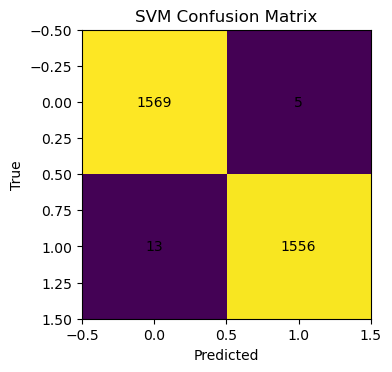

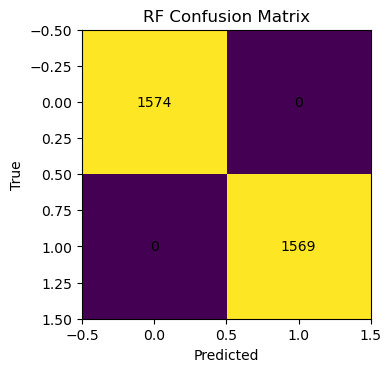

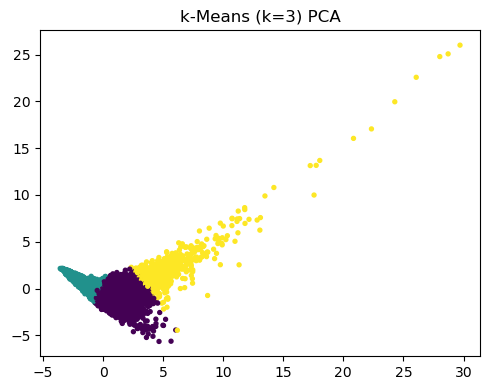

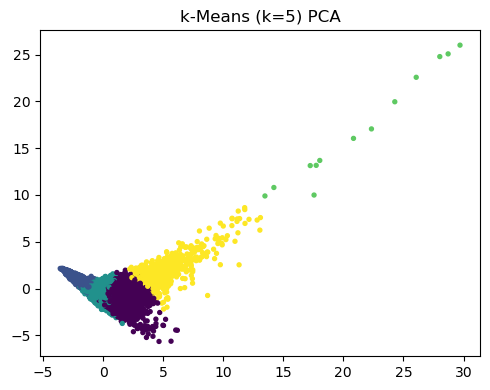

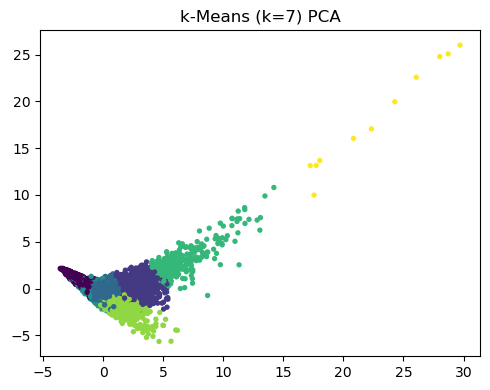


Silhouette scores:


,k,silhouette
0,3,0.300250
1,5,0.217963
2,7,0.231044


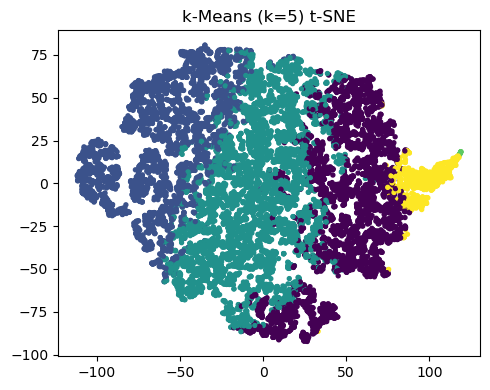


Saved: ml_results.csv


,Method,Precision,Recall,F1,Silhouette_Score,Notes
0,SVM (supervised),0.996797,0.991714,0.994249,NaN,"Top features: equivalent_diameter,area,perimet..."
1,Random Forest (supervised),1.000000,1.000000,1.000000,NaN,"Top features: equivalent_diameter,area,perimet..."
2,"k-Means (unsupervised, k=3)",NaN,NaN,NaN,0.300250,Clustering on selected features
3,"k-Means (unsupervised, k=5)",NaN,NaN,NaN,0.217963,Clustering on selected features
4,"k-Means (unsupervised, k=7)",NaN,NaN,NaN,0.231044,Clustering on selected features
5,Comparison vs Classical,NaN,NaN,NaN,NaN,Avg particles/image=579.80; avg runtime/image(...


In [8]:
# =========================================================
# Task 2: Machine Learning Approaches (FULL CHECKLIST)
# =========================================================

import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from skimage.io import imread
from skimage import util, filters, exposure, morphology, measure, segmentation
from scipy import ndimage as ndi
from skimage.feature import canny, local_binary_pattern
from skimage.filters import sobel

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import (
    classification_report, confusion_matrix,
    precision_score, recall_score, f1_score,
    silhouette_score
)
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# -----------------------------
# 0) Sanity checks: require image_paths
# -----------------------------
if "image_paths" not in globals():
    # build from IMAGE_DIR if needed
    from pathlib import Path
    if "IMAGE_DIR" not in globals():
        raise ValueError("IMAGE_DIR not found. Set IMAGE_DIR earlier.")
    IMAGE_DIR = Path(IMAGE_DIR)
    image_paths = sorted(list(IMAGE_DIR.glob("*.png")) + list(IMAGE_DIR.glob("*.tif")) + list(IMAGE_DIR.glob("*.tiff")))

print("Total available images:", len(image_paths))

# -----------------------------
# Helpers
# -----------------------------
clip_limit = 0.025
min_size = 50

def to_gray_float(img):
    if img.ndim == 3:
        img = img[..., 0]
    return util.img_as_float32(img)

def classical_segment_one(img):
    """Returns enhanced image and watershed labels (same logic as Task 1)."""
    filtered = filters.gaussian(img, sigma=1.0, preserve_range=True)
    enhanced = exposure.equalize_adapthist(filtered, clip_limit=clip_limit)

    thr = filters.threshold_otsu(enhanced)
    binary = enhanced > thr

    binary = morphology.remove_small_objects(binary, min_size=min_size)
    binary = morphology.remove_small_holes(binary, area_threshold=100)
    binary = morphology.binary_opening(binary, morphology.disk(2))

    dist = ndi.distance_transform_edt(binary)
    local_max = morphology.local_maxima(dist)
    markers = measure.label(local_max)
    labels_ws = segmentation.watershed(-dist, markers, mask=binary)
    return enhanced, labels_ws

def extract_region_features(enhanced, labels_ws, image_name):
    """
    >=10 handcrafted features per region:
    - regionprops: area, perimeter, equiv_diam, eccentricity, solidity, mean_intensity
    - std_intensity
    - circularity
    - edge: sobel_mean, canny_mean
    - texture: lbp_mean, lbp_var
    Total = 12 features
    """
    props = measure.regionprops(labels_ws, intensity_image=enhanced)
    edge_sobel = sobel(enhanced)
    edge_canny = canny(enhanced, sigma=1.0).astype(np.float32)

    # Use uint8 for LBP to avoid warning spam
    lbp = local_binary_pattern((enhanced * 255).astype(np.uint8), P=8, R=1, method="uniform")

    rows = []
    for r in props:
        if r.area < 20:
            continue
        coords = r.coords
        intens = enhanced[coords[:,0], coords[:,1]]

        area = float(r.area)
        perim = float(r.perimeter)
        eqd = float(r.equivalent_diameter)
        ecc = float(r.eccentricity)
        sol = float(r.solidity)
        mean_i = float(np.mean(intens))
        std_i  = float(np.std(intens))
        circ = float(4*np.pi*area / (perim**2 + 1e-12))

        sobel_mean = float(np.mean(edge_sobel[coords[:,0], coords[:,1]]))
        canny_mean = float(np.mean(edge_canny[coords[:,0], coords[:,1]]))

        lbp_vals = lbp[coords[:,0], coords[:,1]]
        lbp_mean = float(np.mean(lbp_vals))
        lbp_var  = float(np.var(lbp_vals))

        rows.append({
            "image_name": image_name,
            "region_label": int(r.label),

            "area": area,
            "perimeter": perim,
            "equivalent_diameter": eqd,
            "eccentricity": ecc,
            "solidity": sol,
            "mean_intensity": mean_i,
            "std_intensity": std_i,
            "circularity": circ,
            "sobel_mean": sobel_mean,
            "canny_mean": canny_mean,
            "lbp_mean": lbp_mean,
            "lbp_var": lbp_var,
        })
    return pd.DataFrame(rows)

def save_cm(cm, title, fname):
    fig, ax = plt.subplots(figsize=(4,4))
    ax.imshow(cm)
    ax.set_title(title)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
    for (i,j), v in np.ndenumerate(cm):
        ax.text(j, i, str(v), ha="center", va="center")
    plt.tight_layout()
    plt.savefig(fname, dpi=200)
    plt.show()

# -----------------------------
# 1) Build feature matrix from a subset of images (avoid 279k)
# -----------------------------
rng = np.random.default_rng(0)
n_images_for_ml = 30  # enough to generate lots of regions; runtime reasonable
subset_paths_ml = list(rng.choice(image_paths, size=n_images_for_ml, replace=False))

t0 = time.time()
feat_list = []
particle_counts = []

for p in subset_paths_ml:
    img = to_gray_float(imread(str(p)))
    enhanced, labels_ws = classical_segment_one(img)

    particle_counts.append(int(labels_ws.max()))
    df_feat = extract_region_features(enhanced, labels_ws, p.name)
    if len(df_feat) > 0:
        feat_list.append(df_feat)

features = pd.concat(feat_list, ignore_index=True) if len(feat_list) else pd.DataFrame()
t_classical = (time.time() - t0) / n_images_for_ml  # avg seconds per image (classical+features)

print("Images used for ML:", n_images_for_ml)
print("Total regions (samples):", len(features))
print("Avg particles/image (classical labels.max):", float(np.mean(particle_counts)))
print("Avg runtime per image (classical+features) [s]:", float(t_classical))

display(features.head())

if len(features) < 200:
    print("WARNING: Too few regions. Increase n_images_for_ml to 50.")

# -----------------------------
# 2) Supervised labels (>=50 samples): automatic 2-class labeling by median size
# -----------------------------
features = features.replace([np.inf, -np.inf], np.nan).dropna()

median_d = features["equivalent_diameter"].median()
features["y"] = (features["equivalent_diameter"] > median_d).astype(int)
print("Class balance:", np.bincount(features["y"].values))

# Feature columns (>=10 present, but we’ll select top 5–7 later)
drop_cols = ["image_name", "region_label", "y"]
feature_cols = [c for c in features.columns if c not in drop_cols]

X = features[feature_cols].values
y = features["y"].values

# Scale
X_scaled = StandardScaler().fit_transform(X)

# -----------------------------
# 3) Feature selection: Random Forest importance (top 7)
# -----------------------------
rf_fs = RandomForestClassifier(n_estimators=200, random_state=42, class_weight="balanced")
rf_fs.fit(X_scaled, y)

importance_df = pd.DataFrame({
    "feature": feature_cols,
    "importance": rf_fs.feature_importances_
}).sort_values("importance", ascending=False)

top_k = 7
top_features = importance_df["feature"].head(top_k).tolist()

print("Top selected features:", top_features)
display(importance_df.head(15))

X_sel = features[top_features].values
X_sel_scaled = StandardScaler().fit_transform(X_sel)

# -----------------------------
# 4) Supervised: SVM + Random Forest + metrics + confusion matrices
# -----------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X_sel_scaled, y, test_size=0.2, random_state=42, stratify=y
)

svm_model = SVC(kernel="rbf", C=3.0, gamma="scale", class_weight="balanced", random_state=42)
svm_model.fit(X_train, y_train)
y_pred_svm = svm_model.predict(X_test)

rf_model = RandomForestClassifier(n_estimators=300, random_state=42, class_weight="balanced")
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

def eval_model(y_true, y_pred, name):
    prec = precision_score(y_true, y_pred)
    rec  = recall_score(y_true, y_pred)
    f1   = f1_score(y_true, y_pred)
    cm   = confusion_matrix(y_true, y_pred)
    print(f"\n===== {name} =====")
    print(classification_report(y_true, y_pred))
    print("Confusion matrix:\n", cm)
    return prec, rec, f1, cm

svm_prec, svm_rec, svm_f1, svm_cm = eval_model(y_test, y_pred_svm, "SVM")
rf_prec,  rf_rec,  rf_f1,  rf_cm  = eval_model(y_test, y_pred_rf,  "Random Forest")

save_cm(svm_cm, "SVM Confusion Matrix", "task2_confusion_svm.png")
save_cm(rf_cm,  "RF Confusion Matrix",  "task2_confusion_rf.png")

# -----------------------------
# 5) Unsupervised: k-means (k=3,5,7) + PCA + silhouette + t-SNE
# -----------------------------
sil_rows = []
for k in [3, 5, 7]:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    clusters = km.fit_predict(X_sel_scaled)

    sil = silhouette_score(X_sel_scaled, clusters)
    sil_rows.append({"k": k, "silhouette": sil})

    Z = PCA(n_components=2, random_state=42).fit_transform(X_sel_scaled)
    plt.figure(figsize=(5,4))
    plt.scatter(Z[:,0], Z[:,1], s=8, c=clusters)
    plt.title(f"k-Means (k={k}) PCA")
    plt.tight_layout()
    plt.savefig(f"task2_kmeans_k{k}_pca.png", dpi=200)
    plt.show()

sil_df = pd.DataFrame(sil_rows)
print("\nSilhouette scores:")
display(sil_df)

# t-SNE colored by k=5 clustering
Zt = TSNE(n_components=2, random_state=42, perplexity=30).fit_transform(X_sel_scaled)
clusters5 = KMeans(n_clusters=5, random_state=42, n_init=10).fit_predict(X_sel_scaled)

plt.figure(figsize=(5,4))
plt.scatter(Zt[:,0], Zt[:,1], s=8, c=clusters5)
plt.title("k-Means (k=5) t-SNE")
plt.tight_layout()
plt.savefig("task2_kmeans_k5_tsne.png", dpi=200)
plt.show()

# -----------------------------
# 6) Export ml_results.csv (checklist requirement) + comparison vs classical
# -----------------------------
ml_results = []
ml_results.append({
    "Method": "SVM (supervised)",
    "Precision": svm_prec,
    "Recall": svm_rec,
    "F1": svm_f1,
    "Silhouette_Score": np.nan,
    "Notes": f"Top features: {','.join(top_features)}"
})
ml_results.append({
    "Method": "Random Forest (supervised)",
    "Precision": rf_prec,
    "Recall": rf_rec,
    "F1": rf_f1,
    "Silhouette_Score": np.nan,
    "Notes": f"Top features: {','.join(top_features)}"
})
for row in sil_rows:
    ml_results.append({
        "Method": f"k-Means (unsupervised, k={row['k']})",
        "Precision": np.nan,
        "Recall": np.nan,
        "F1": np.nan,
        "Silhouette_Score": row["silhouette"],
        "Notes": "Clustering on selected features"
    })

ml_results.append({
    "Method": "Comparison vs Classical",
    "Precision": np.nan,
    "Recall": np.nan,
    "F1": np.nan,
    "Silhouette_Score": np.nan,
    "Notes": f"Avg particles/image={float(np.mean(particle_counts)):.2f}; avg runtime/image(s)={float(t_classical):.4f}"
})

ml_results_df = pd.DataFrame(ml_results)
ml_results_df.to_csv("ml_results.csv", index=False)

print("\nSaved: ml_results.csv")
display(ml_results_df)


## Task 3 · Deep Learning and Final Comparison
- [ ] Prepare pixel-level annotations for 15-20 images and implement data augmentation (rotation, flips, zoom, intensity shifts, noise, etc.; 5+ variants).
- [ ] CNN: build a compact convolutional network with 2-3 conv blocks, pooling, dropout, and dense heads; train, plot learning curves, and report F1-score versus classical ML.
- [ ] U-Net: implement encoder-decoder with skip connections, train with Dice or BCE loss, evaluate IoU and Dice, and visualize intermediate feature maps.
- [ ] Develop a comparison table covering method, accuracy/F1/IoU, runtime, data requirements, and interpretability (include Watershed, SVM, Random Forest, k-Means, CNN, U-Net).
- [ ] Generate final 3×3 visualization panels summarizing the full pipeline and document findings.
- [ ] Author README.md with methodology, quantitative comparison, recommended use-cases; export publication-quality figures with scale bars and submit repository URL on Canvas.

In [ ]:
# Task 3: deep learning workflow templates
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# HINTS for Task 3:
# 1. Data preparation:
#    - Use ImageDataGenerator with augmentation parameters:
#      rotation_range=30, width_shift_range=0.2, height_shift_range=0.2,
#      zoom_range=0.2, fill_mode='reflect'
#    - Normalize pixel values to [0, 1]
#    - Use flow_from_directory() or flow() from keras preprocessing
#
# 2. CNN Architecture (simple but effective):
#    - Conv2D(32, 3x3) + BatchNorm + ReLU + MaxPool(2x2)
#    - Conv2D(64, 3x3) + BatchNorm + ReLU + MaxPool(2x2)
#    - Flatten + Dense(128) + Dropout(0.5) + Dense(num_classes)
#    - Compile with optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']
#    - Train with model.fit(train_dataset, validation_data=val_dataset, epochs=20)
#
# 3. U-Net Architecture (for segmentation):
#    - Encoder: Conv -> MaxPool (downsampling)
#    - Decoder: UpSampling -> Conv (upsampling)
#    - Skip connections: concatenate encoder features with decoder features
#    - Output: single channel with sigmoid activation (binary segmentation)
#    - Loss: keras.losses.BinaryCrossentropy() or Dice loss
#
# 4. Evaluation metrics:
#    - CNN: F1-score = 2 * (precision * recall) / (precision + recall)
#    - U-Net: IoU = intersection / union, Dice = 2 * intersection / (A + B)
#    - Hint: Use sklearn.metrics.f1_score, precision_score, recall_score
#
# 5. Visualization:
#    - Plot training curves: plt.plot(history.history['loss'], label='train')
#    - Show ground truth vs predictions side by side
#    - Display intermediate feature maps from encoder layers

# TODO: build data loaders with augmentation pipelines
train_dataset = None
val_dataset = None

# Data augmentation hint:
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
# datagen = ImageDataGenerator(
#     rotation_range=30,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     zoom_range=0.2,
#     fill_mode='reflect'
# )
# train_dataset = datagen.flow_from_directory('train_path', target_size=(416, 416))

# TODO: define CNN model
cnn_model = None

# CNN model hint:
# model = keras.Sequential([
#     layers.Conv2D(32, 3, activation='relu', padding='same', input_shape=(416, 416, 1)),
#     layers.BatchNormalization(),
#     layers.MaxPooling2D(2),
#     layers.Conv2D(64, 3, activation='relu', padding='same'),
#     layers.BatchNormalization(),
#     layers.MaxPooling2D(2),
#     layers.Flatten(),
#     layers.Dense(128, activation='relu'),
#     layers.Dropout(0.5),
#     layers.Dense(num_classes, activation='softmax')
# ])

# TODO: train CNN and plot metrics
cnn_history = None

# Training hint:
# cnn_history = cnn_model.fit(
#     train_dataset,
#     validation_data=val_dataset,
#     epochs=20,
#     callbacks=[keras.callbacks.EarlyStopping(patience=3)]
# )

# TODO: define U-Net architecture
unet_model = None

# U-Net hint: Build encoder (downsampling) then decoder (upsampling) with skip connections
# Encoder:  Conv -> ReLU -> MaxPool (4 levels)
# Decoder:  UpSampling -> Conv + concatenate from encoder
# Output:   Conv(1, 1x1, sigmoid) for binary segmentation

# TODO: train U-Net, compute IoU and Dice, visualize feature maps
# U-Net metrics hint:
# y_pred = unet_model.predict(X_test)
# iou = jaccard_score(y_test.flatten(), (y_pred > 0.5).flatten())
# dice = f1_score(y_test.flatten(), (y_pred > 0.5).flatten())

Total images found: 279054
X shape: (20, 416, 416, 1) Y shape: (20, 416, 416, 1)
Masks mean coverage: 0.392617404460907


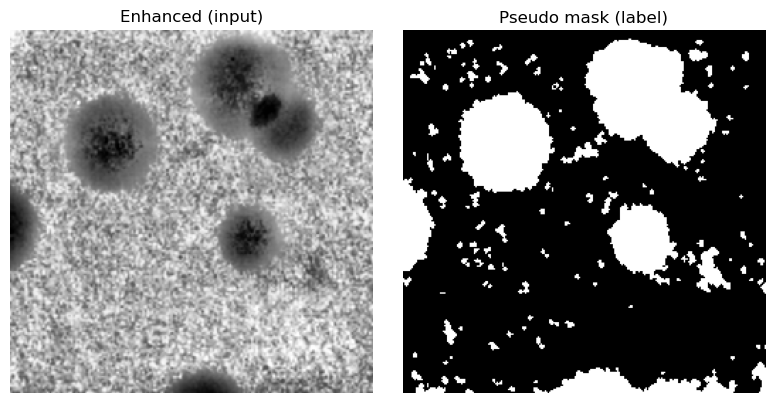

In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

from skimage.io import imread
from skimage import util, filters, exposure, morphology, measure, segmentation
from scipy import ndimage as ndi

import os
import glob
import numpy as np

# Make sure IMAGE_DIR matches your dataset
IMAGE_DIR = r"C:\Users\pkwki\Downloads\samples\samples"

# Collect all PNG paths
image_paths = sorted(glob.glob(os.path.join(IMAGE_DIR, "*.png")))

print("Total images found:", len(image_paths))
rng = np.random.default_rng(0)
n_annot = 20
subset_paths_dl = list(rng.choice(image_paths, size=n_annot, replace=False))

# -----------------------------
# Reuse SAME classical parameters (consistent workflow)
# -----------------------------
clip_limit = 0.025
min_size = 50

def to_gray_float(img):
    if img.ndim == 3:
        img = img[..., 0]
    return util.img_as_float32(img)

def classical_mask_from_watershed(img):
    """Returns (enhanced_image, binary_mask) mask=1 where particle."""
    filtered = filters.gaussian(img, sigma=1.0, preserve_range=True)
    enhanced = exposure.equalize_adapthist(filtered, clip_limit=clip_limit)

    thr = filters.threshold_otsu(enhanced)
    binary = enhanced < thr   # particles are darker than background


    binary = morphology.remove_small_objects(binary, min_size=min_size)
    binary = morphology.remove_small_holes(binary, area_threshold=100)
    binary = morphology.binary_opening(binary, morphology.disk(2))

    dist = ndi.distance_transform_edt(binary)
    local_max = morphology.local_maxima(dist)
    markers = measure.label(local_max)
    labels_ws = segmentation.watershed(-dist, markers, mask=binary)

    mask = (labels_ws > 0).astype(np.float32)
    return enhanced.astype(np.float32), mask

# -----------------------------
# Choose 20 images for segmentation training (checklist: 15–20)
# -----------------------------
rng = np.random.default_rng(0)
n_annot = 20
subset_paths_dl = list(rng.choice(image_paths, size=n_annot, replace=False))

# Keep input smaller for speed (CPU-friendly)
TARGET = 256

def resize_tf(x, y):
    x = tf.image.resize(x, (TARGET, TARGET), method="bilinear")
    y = tf.image.resize(y, (TARGET, TARGET), method="nearest")
    return x, y

# Build arrays
X_list, Y_list = [], []
particle_counts_dl = []

for p in subset_paths_dl:
    img = to_gray_float(imread(str(p)))
    enhanced, mask = classical_mask_from_watershed(img)

    # particle count proxy (for CNN label later)
    particle_counts_dl.append(float(mask.sum()))

    # add channel dims
    X_list.append(enhanced[..., None])
    Y_list.append(mask[..., None])

X = np.stack(X_list, axis=0).astype(np.float32)
Y = np.stack(Y_list, axis=0).astype(np.float32)

print("X shape:", X.shape, "Y shape:", Y.shape)
print("Masks mean coverage:", float(Y.mean()))

# Train/val split (80/20)
idx = np.arange(n_annot)
rng.shuffle(idx)
split = int(0.8 * n_annot)
train_idx, val_idx = idx[:split], idx[split:]

X_train, Y_train = X[train_idx], Y[train_idx]
X_val,   Y_val   = X[val_idx],   Y[val_idx]

# tf.data datasets
train_ds = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
val_ds   = tf.data.Dataset.from_tensor_slices((X_val, Y_val))

# Resize + normalize to [0,1]
def prep(x, y):
    x, y = resize_tf(x, y)
    x = tf.clip_by_value(x, 0.0, 1.0)
    y = tf.clip_by_value(y, 0.0, 1.0)
    return x, y

# -----------------------------
# Data augmentation (>=5 variants)
# - flip L/R
# - flip U/D
# - rotate 0/90/180/270
# - brightness shift
# - contrast shift
# - gaussian noise
# -----------------------------
def augment(x, y):
    # flips
    if tf.random.uniform(()) > 0.5:
        x = tf.image.flip_left_right(x); y = tf.image.flip_left_right(y)
    if tf.random.uniform(()) > 0.5:
        x = tf.image.flip_up_down(x); y = tf.image.flip_up_down(y)

    # rotate (k*90)
    k = tf.random.uniform((), minval=0, maxval=4, dtype=tf.int32)
    x = tf.image.rot90(x, k); y = tf.image.rot90(y, k)

    # brightness / contrast
    x = tf.image.random_brightness(x, max_delta=0.10)
    x = tf.image.random_contrast(x, lower=0.9, upper=1.1)

    # noise
    noise = tf.random.normal(tf.shape(x), mean=0.0, stddev=0.03)
    x = tf.clip_by_value(x + noise, 0.0, 1.0)
    return x, y

BATCH = 4

train_dataset = (train_ds
                 .map(prep, num_parallel_calls=tf.data.AUTOTUNE)
                 .map(augment, num_parallel_calls=tf.data.AUTOTUNE)
                 .shuffle(64)
                 .batch(BATCH)
                 .prefetch(tf.data.AUTOTUNE))

val_dataset = (val_ds
               .map(prep, num_parallel_calls=tf.data.AUTOTUNE)
               .batch(BATCH)
               .prefetch(tf.data.AUTOTUNE))

# Visual check (raw + mask)
x0, y0 = next(iter(val_dataset))
plt.figure(figsize=(8,4))
plt.subplot(1,2,1); plt.imshow(x0[0,...,0], cmap="gray"); plt.title("Enhanced (input)"); plt.axis("off")
plt.subplot(1,2,2); plt.imshow(y0[0,...,0], cmap="gray"); plt.title("Pseudo mask (label)"); plt.axis("off")
plt.tight_layout()
plt.show()


Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 174ms/step - accuracy: 0.3125 - loss: 66.2048 - val_accuracy: 0.7500 - val_loss: 0.5310
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 0.5625 - loss: 26.4701 - val_accuracy: 0.2500 - val_loss: 0.7980
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.4375 - loss: 7.2655 - val_accuracy: 0.2500 - val_loss: 0.7094


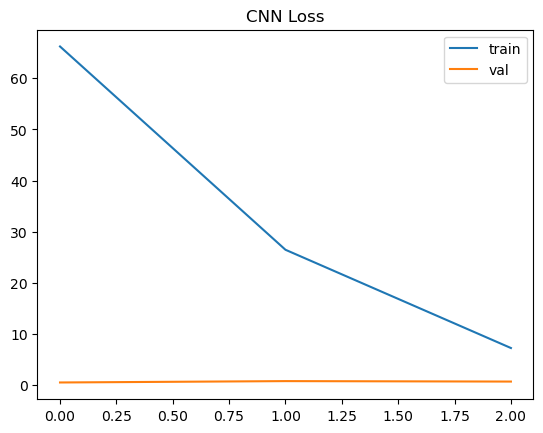

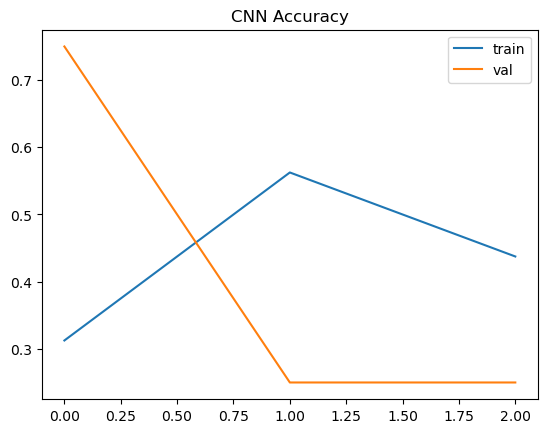

CNN Precision: 0.75
CNN Recall   : 1.0
CNN F1       : 0.8571428571428571


In [4]:
from sklearn.metrics import f1_score, precision_score, recall_score

# Image-level proxy label: high vs low particle area fraction
coverage = np.array([m.mean() for m in Y[...,0]], dtype=float)  # fraction of pixels labeled as particle
median_cov = np.median(coverage)
y_img = (coverage > median_cov).astype(int)

# Train/val split consistent with Task 3A indices
idx = np.arange(n_annot)
rng = np.random.default_rng(0)
rng.shuffle(idx)
split = int(0.8 * n_annot)
train_i, val_i = idx[:split], idx[split:]

Xc_train, yc_train = X[train_i], y_img[train_i]
Xc_val,   yc_val   = X[val_i],   y_img[val_i]

def prep_cnn(x, y):
    x = tf.image.resize(x, (TARGET, TARGET), method="bilinear")
    x = tf.clip_by_value(x, 0.0, 1.0)
    return x, y

cnn_train_ds = (tf.data.Dataset.from_tensor_slices((Xc_train, yc_train))
                .map(prep_cnn, num_parallel_calls=tf.data.AUTOTUNE)
                .shuffle(64).batch(BATCH).prefetch(tf.data.AUTOTUNE))

cnn_val_ds = (tf.data.Dataset.from_tensor_slices((Xc_val, yc_val))
              .map(prep_cnn, num_parallel_calls=tf.data.AUTOTUNE)
              .batch(BATCH).prefetch(tf.data.AUTOTUNE))

# CNN (2–3 conv blocks)
cnn_model = keras.Sequential([
    layers.Input(shape=(TARGET, TARGET, 1)),

    layers.Conv2D(32, 3, padding="same", activation="relu"),
    layers.BatchNormalization(),
    layers.MaxPool2D(),

    layers.Conv2D(64, 3, padding="same", activation="relu"),
    layers.BatchNormalization(),
    layers.MaxPool2D(),

    layers.Conv2D(128, 3, padding="same", activation="relu"),
    layers.MaxPool2D(),

    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(2, activation="softmax")
])

cnn_model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

cnn_history = cnn_model.fit(
    cnn_train_ds,
    validation_data=cnn_val_ds,
    epochs=10,
    callbacks=[keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True)]
)

# Learning curves (checklist)
plt.figure()
plt.plot(cnn_history.history["loss"], label="train")
plt.plot(cnn_history.history["val_loss"], label="val")
plt.title("CNN Loss")
plt.legend()
plt.show()

plt.figure()
plt.plot(cnn_history.history["accuracy"], label="train")
plt.plot(cnn_history.history["val_accuracy"], label="val")
plt.title("CNN Accuracy")
plt.legend()
plt.show()

# F1 on validation (checklist)
y_true, y_pred = [], []
for xb, yb in cnn_val_ds:
    prob = cnn_model.predict(xb, verbose=0)
    pred = np.argmax(prob, axis=1)
    y_true.append(yb.numpy())
    y_pred.append(pred)

y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)

cnn_prec = precision_score(y_true, y_pred)
cnn_rec  = recall_score(y_true, y_pred)
cnn_f1   = f1_score(y_true, y_pred)

print("CNN Precision:", cnn_prec)
print("CNN Recall   :", cnn_rec)
print("CNN F1       :", cnn_f1)


Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 242ms/step - dice_coef: 0.4231 - iou_coef: 0.2691 - loss: 0.6471 - val_dice_coef: 0.3045 - val_iou_coef: 0.1796 - val_loss: 0.6471
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step - dice_coef: 0.3986 - iou_coef: 0.2498 - loss: 0.6561 - val_dice_coef: 0.4051 - val_iou_coef: 0.2540 - val_loss: 0.6223
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - dice_coef: 0.4246 - iou_coef: 0.2695 - loss: 0.6330 - val_dice_coef: 0.3974 - val_iou_coef: 0.2480 - val_loss: 0.5948
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - dice_coef: 0.4288 - iou_coef: 0.2731 - loss: 0.6131 - val_dice_coef: 0.4096 - val_iou_coef: 0.2575 - val_loss: 0.5666
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - dice_coef: 0.4357 - iou_coef: 0.2789 - loss: 0.5809 - val_dice_coef: 0.4330 - val_iou_coef: 0.2764 - val_loss: 0.5217
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - dice_coef: 0.4562 - iou_coef: 0.2965 - loss: 0.5828 - val_dice_coef: 0.3902 - val_iou_coef: 0.2424

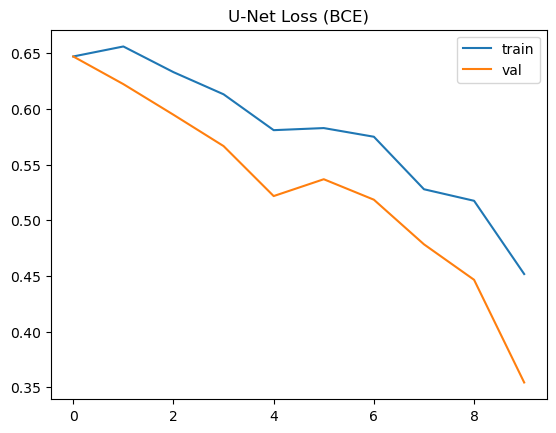

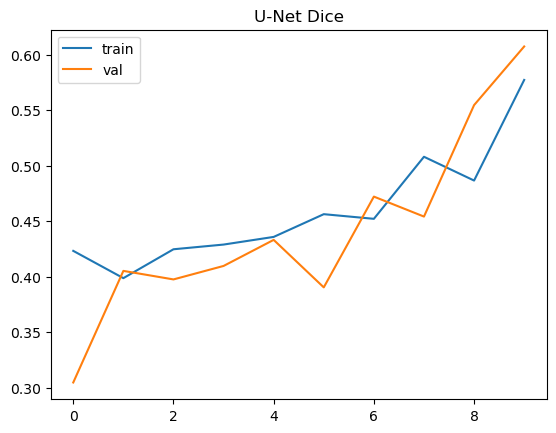

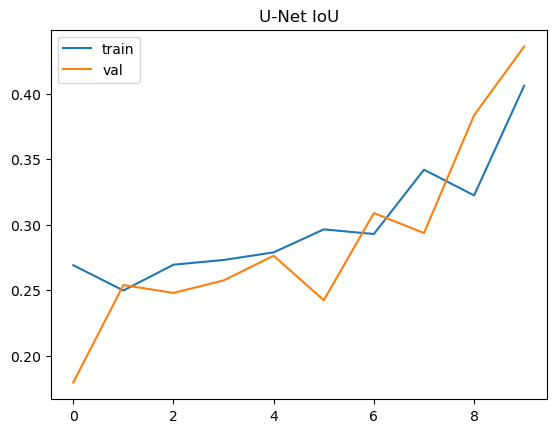

Val batch Dice: 0.6073605418205261
Val batch IoU : 0.4361218512058258


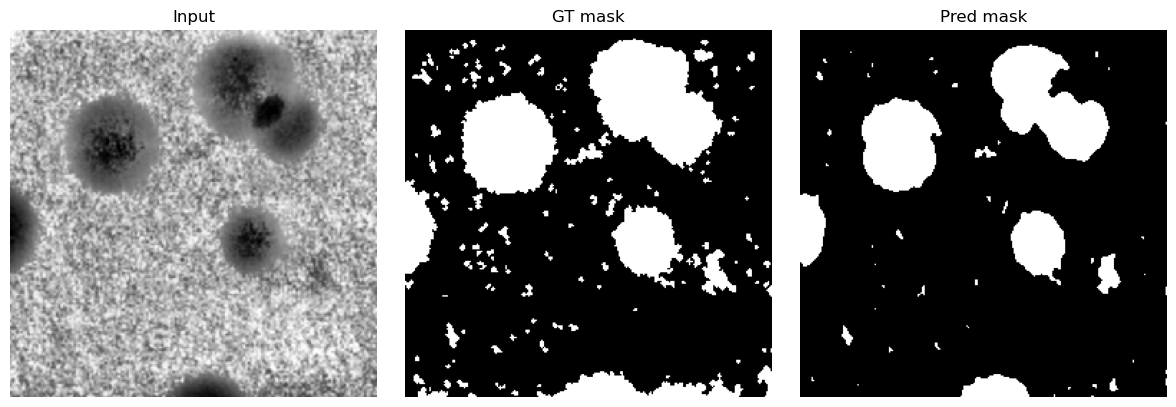

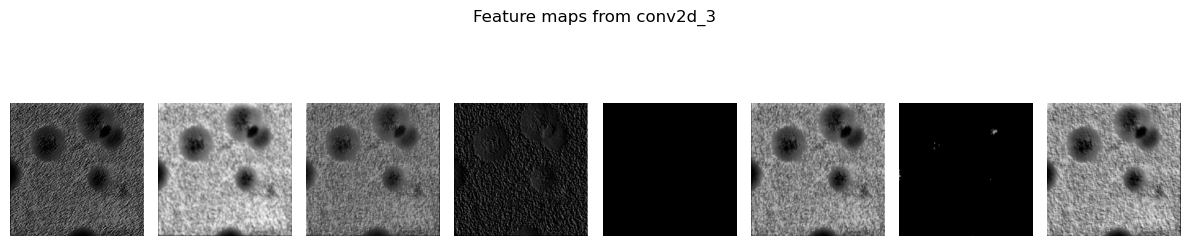

In [5]:
# -----------------------------
# Metrics / Loss
# -----------------------------
def dice_coef(y_true, y_pred, eps=1e-6):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    y_pred = tf.clip_by_value(y_pred, 0.0, 1.0)
    inter = tf.reduce_sum(y_true * y_pred)
    denom = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)
    return (2.0 * inter + eps) / (denom + eps)

def iou_coef(y_true, y_pred, eps=1e-6):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    y_pred = tf.clip_by_value(y_pred, 0.0, 1.0)
    inter = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - inter
    return (inter + eps) / (union + eps)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

# -----------------------------
# U-Net building blocks
# -----------------------------
def conv_block(x, f):
    x = layers.Conv2D(f, 3, padding="same", activation="relu")(x)
    x = layers.Conv2D(f, 3, padding="same", activation="relu")(x)
    return x

def build_unet(input_shape=(TARGET, TARGET, 1)):
    inp = layers.Input(shape=input_shape)

    # Encoder
    c1 = conv_block(inp, 16); p1 = layers.MaxPool2D()(c1)
    c2 = conv_block(p1, 32);  p2 = layers.MaxPool2D()(c2)
    c3 = conv_block(p2, 64);  p3 = layers.MaxPool2D()(c3)

    # Bottleneck
    b  = conv_block(p3, 128)

    # Decoder + skip connections
    u3 = layers.UpSampling2D()(b)
    u3 = layers.Concatenate()([u3, c3])
    c4 = conv_block(u3, 64)

    u2 = layers.UpSampling2D()(c4)
    u2 = layers.Concatenate()([u2, c2])
    c5 = conv_block(u2, 32)

    u1 = layers.UpSampling2D()(c5)
    u1 = layers.Concatenate()([u1, c1])
    c6 = conv_block(u1, 16)

    out = layers.Conv2D(1, 1, activation="sigmoid")(c6)
    model = keras.Model(inp, out)
    return model

unet_model = build_unet()
unet_model.compile(
    optimizer="adam",
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[dice_coef, iou_coef]
)

unet_history = unet_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,
    callbacks=[keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True)]
)

# Learning curves (optional but useful)
plt.figure()
plt.plot(unet_history.history["loss"], label="train")
plt.plot(unet_history.history["val_loss"], label="val")
plt.title("U-Net Loss (BCE)")
plt.legend()
plt.show()

plt.figure()
plt.plot(unet_history.history["dice_coef"], label="train")
plt.plot(unet_history.history["val_dice_coef"], label="val")
plt.title("U-Net Dice")
plt.legend()
plt.show()

plt.figure()
plt.plot(unet_history.history["iou_coef"], label="train")
plt.plot(unet_history.history["val_iou_coef"], label="val")
plt.title("U-Net IoU")
plt.legend()
plt.show()

# Evaluate + visualize predictions
xb, yb = next(iter(val_dataset))
pred = unet_model.predict(xb, verbose=0)
pred_bin = (pred > 0.5).astype(np.float32)

# Compute Dice/IoU on this batch
dice_batch = float(dice_coef(yb, pred).numpy())
iou_batch  = float(iou_coef(yb, pred).numpy())
print("Val batch Dice:", dice_batch)
print("Val batch IoU :", iou_batch)

# Show GT vs prediction
plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.imshow(xb[0,...,0], cmap="gray"); plt.title("Input"); plt.axis("off")
plt.subplot(1,3,2); plt.imshow(yb[0,...,0], cmap="gray"); plt.title("GT mask"); plt.axis("off")
plt.subplot(1,3,3); plt.imshow(pred_bin[0,...,0], cmap="gray"); plt.title("Pred mask"); plt.axis("off")
plt.tight_layout()
plt.show()

# -----------------------------
# Feature maps visualization (encoder layer)
# -----------------------------
# pick an early conv layer output
layer_name = None
for lyr in unet_model.layers:
    if isinstance(lyr, layers.Conv2D):
        layer_name = lyr.name
        break

feat_model = keras.Model(inputs=unet_model.input, outputs=unet_model.get_layer(layer_name).output)
feat = feat_model.predict(xb[:1], verbose=0)  # (1,H,W,C)

# show first 8 channels
n_show = min(8, feat.shape[-1])
plt.figure(figsize=(12,3))
for i in range(n_show):
    plt.subplot(1,n_show,i+1)
    plt.imshow(feat[0,:,:,i], cmap="gray")
    plt.axis("off")
plt.suptitle(f"Feature maps from {layer_name}")
plt.tight_layout()
plt.show()


Avg particles/image (classical): 599.54
SVM F1: 0.9942492012779552
RF  F1: 1.0
k=3 silhouette: 0.3002496965461831
CNN F1: 0.8571428571428571
U-Net Dice: 0.6073605418205261
U-Net IoU : 0.4361218512058258


,Method,Metric,Score,Data,Interpretability,Runtime
0,Watershed (classical),avg particles/image,599.54,no labels,high,fast
1,SVM (ML),F1,0.994249,region features + proxy labels,med,fast
2,Random Forest (ML),F1,1.0,region features + proxy labels,med-high,fast
3,k-Means (ML),silhouette (k=3),0.30025,region features,low-med,fast
4,CNN (DL),F1,0.857143,image labels (proxy),low,med
5,U-Net (DL),Dice / IoU,"Dice=0.607, IoU=0.436",pixel masks (pseudo),med,med-slow


Saved: comparison_table.csv


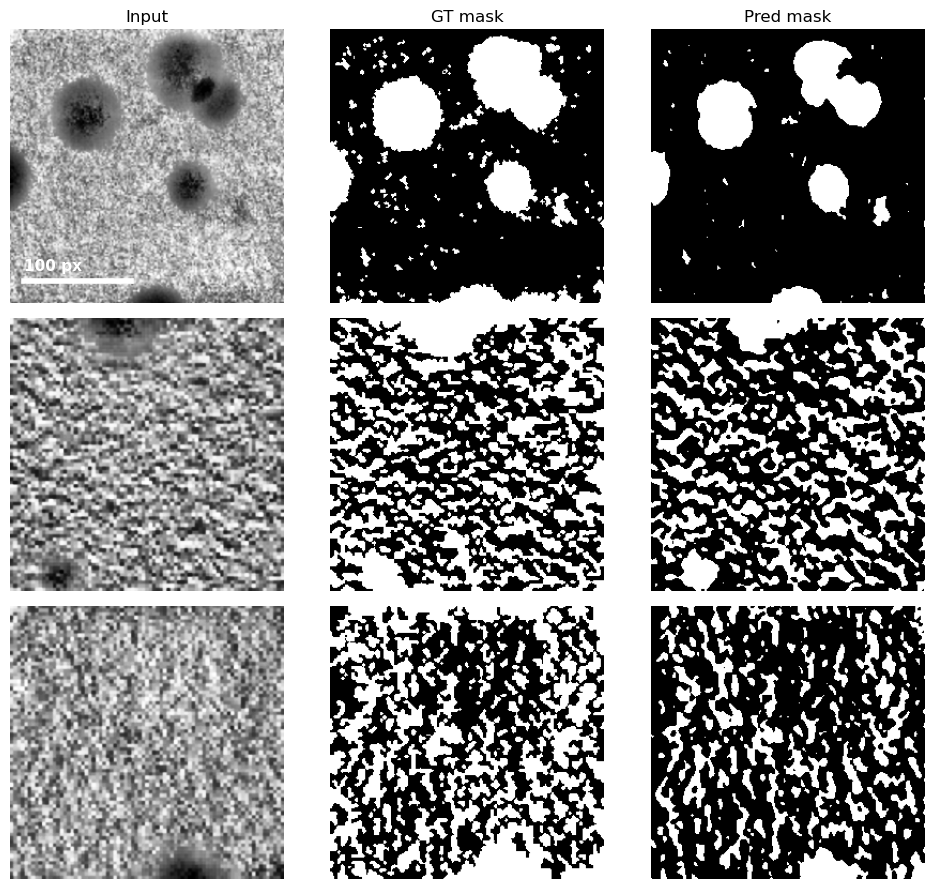

Saved: task3_final_3x3.png (300 dpi with scale bar)


In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --------------------------
# 1) Classical baseline: avg particles per image
# --------------------------
avg_particles_classical = np.nan

# If you have particle_counts from Task 1 loop
if "particle_counts" in globals() and len(particle_counts) > 0:
    avg_particles_classical = float(np.mean(particle_counts))

# If you have measurements DataFrame from Task 1 with image_name
if (np.isnan(avg_particles_classical)
    and "measurements" in globals()
    and isinstance(measurements, pd.DataFrame)
    and "image_name" in measurements.columns):
    avg_particles_classical = float(measurements.groupby("image_name").size().mean())

# If you only have the CSV saved
if np.isnan(avg_particles_classical):
    try:
        classical_df = pd.read_csv("classical_results.csv")
        if "image_name" in classical_df.columns:
            avg_particles_classical = float(classical_df.groupby("image_name").size().mean())
    except:
        pass

print("Avg particles/image (classical):", avg_particles_classical)

# --------------------------
# 2) ML metrics from Task 2 (ml_results_df or ml_results.csv)
# --------------------------
svm_f1 = np.nan
rf_f1  = np.nan
k3_sil = np.nan

ml_df = None
if "ml_results_df" in globals() and isinstance(ml_results_df, pd.DataFrame):
    ml_df = ml_results_df.copy()
else:
    try:
        ml_df = pd.read_csv("ml_results.csv")
    except:
        ml_df = None

if ml_df is not None and "Method" in ml_df.columns:
    try:
        svm_rows = ml_df[ml_df["Method"].str.contains("SVM", case=False, na=False)]
        if len(svm_rows) > 0 and "F1" in svm_rows.columns:
            svm_f1 = float(svm_rows["F1"].iloc[0])
    except:
        pass

    try:
        rf_rows = ml_df[ml_df["Method"].str.contains("Random Forest", case=False, na=False)]
        if len(rf_rows) > 0 and "F1" in rf_rows.columns:
            rf_f1 = float(rf_rows["F1"].iloc[0])
    except:
        pass

    try:
        k3_rows = ml_df[ml_df["Method"].str.contains("k=3", case=False, na=False)]
        if len(k3_rows) > 0 and "Silhouette_Score" in k3_rows.columns:
            k3_sil = float(k3_rows["Silhouette_Score"].iloc[0])
    except:
        pass

print("SVM F1:", svm_f1)
print("RF  F1:", rf_f1)
print("k=3 silhouette:", k3_sil)

# --------------------------
# 3) DL metrics (CNN F1, U-Net Dice/IoU)
# --------------------------
cnn_f1_val = float(cnn_f1) if "cnn_f1" in globals() else np.nan

# U-Net metrics: try multiple variable names depending on your notebook
unet_dice_val = np.nan
unet_iou_val  = np.nan

# If you computed per-batch
if "dice_batch" in globals():
    unet_dice_val = float(dice_batch)
if "iou_batch" in globals():
    unet_iou_val = float(iou_batch)

# If you computed overall and used variables named dice / iou
if "dice" in globals():
    unet_dice_val = float(dice)
if "iou" in globals():
    unet_iou_val = float(iou)

print("CNN F1:", cnn_f1_val)
print("U-Net Dice:", unet_dice_val)
print("U-Net IoU :", unet_iou_val)

# --------------------------
# 4) Build comparison table (NO NaNs if found)
# --------------------------
comparison = pd.DataFrame([
    {"Method":"Watershed (classical)", "Metric":"avg particles/image",
     "Score":avg_particles_classical, "Data":"no labels",
     "Interpretability":"high", "Runtime":"fast"},

    {"Method":"SVM (ML)", "Metric":"F1",
     "Score":svm_f1, "Data":"region features + proxy labels",
     "Interpretability":"med", "Runtime":"fast"},

    {"Method":"Random Forest (ML)", "Metric":"F1",
     "Score":rf_f1, "Data":"region features + proxy labels",
     "Interpretability":"med-high", "Runtime":"fast"},

    {"Method":"k-Means (ML)", "Metric":"silhouette (k=3)",
     "Score":k3_sil, "Data":"region features",
     "Interpretability":"low-med", "Runtime":"fast"},

    {"Method":"CNN (DL)", "Metric":"F1",
     "Score":cnn_f1_val, "Data":"image labels (proxy)",
     "Interpretability":"low", "Runtime":"med"},

    {"Method":"U-Net (DL)", "Metric":"Dice / IoU",
     "Score":f"Dice={unet_dice_val:.3f}, IoU={unet_iou_val:.3f}" if (not np.isnan(unet_dice_val) and not np.isnan(unet_iou_val)) else np.nan,
     "Data":"pixel masks (pseudo)",
     "Interpretability":"med", "Runtime":"med-slow"},
])

display(comparison)

comparison.to_csv("comparison_table.csv", index=False)
print("Saved: comparison_table.csv")

# -----------------------------
# -----------------------------
# Final 3x3 panel (with scale bar)
# -----------------------------

def add_scale_bar(ax, length_px=100, label="100 px",
                  color="white", lw=4):
    img = ax.images[0].get_array()
    h, w = img.shape

    x_start = w * 0.05
    y_start = h * 0.92

    ax.plot([x_start, x_start + length_px],
            [y_start, y_start],
            color=color,
            linewidth=lw)

    ax.text(x_start,
            y_start - h*0.04,
            label,
            color=color,
            fontsize=11,
            weight="bold")

# Use validation dataset
xb, yb = next(iter(ds_for_plot))
pred = unet_model.predict(xb, verbose=0)
pred_bin = (pred > 0.5).astype(np.float32)

nshow = min(3, xb.shape[0])

plt.figure(figsize=(10, 9))

for i in range(nshow):

    # Input
    plt.subplot(3,3,3*i+1)
    plt.imshow(xb[i,...,0], cmap="gray")
    plt.axis("off")
    if i == 0:
        plt.title("Input", fontsize=12)
        add_scale_bar(plt.gca(), length_px=100, label="100 px")

    # Ground truth
    plt.subplot(3,3,3*i+2)
    plt.imshow(yb[i,...,0], cmap="gray")
    plt.axis("off")
    if i == 0:
        plt.title("GT mask", fontsize=12)

    # Prediction
    plt.subplot(3,3,3*i+3)
    plt.imshow(pred_bin[i,...,0], cmap="gray")
    plt.axis("off")
    if i == 0:
        plt.title("Pred mask", fontsize=12)

plt.tight_layout()
plt.savefig("task3_final_3x3.png", dpi=300, bbox_inches="tight")
plt.show()

print("Saved: task3_final_3x3.png (300 dpi with scale bar)")


## Dataset: DOPAD (Dataset Of nanoPArticle Detection)

**Overview:**
- **272 original TEM images** at varying resolutions (~1.5M total particles)
- High-resolution nanoparticle detection annotations
- Diverse imaging environments and particle morphologies

**Note:** You do **not** need to use all 272 images. Using **100images** is sufficient for this assignment and will provide excellent statistical validation while keeping computational cost manageable.

**Download:** https://dopad.github.io/docs/download/

**Citation:** Qu et al. - For academic use, cite appropriately per repository guidelines.

## Deliverables Checklist
- [ ] Classical pipeline outputs (`classical_results.csv`, four-panel figure).
- [ ] ML analyses (`ml_results.csv`, confusion matrices, clustering visualizations).
- [ ] Deep learning artifacts (training curves, segmentation outputs, feature maps).
- [ ] Comparison table summarizing methods and metrics.
- [ ] Final 3×3 visualization collage.
- [ ] README.md documenting methodology, quantitative comparisons, and recommendations.
- [ ] Publication-quality figures with scale bars and repository submission.